In [1]:
import sqlite3, pandas as pd
conn = sqlite3.connect("olist.db")

orders_t, items_t, reviews_t = "orders", "order_items", "order_reviews"
order_id_col, customer_id_col = "order_id", "customer_id"
order_status_col = "order_status"
purchase_ts_col = "order_purchase_timestamp"
delivered_date_col = "order_delivered_customer_date"
eta_date_col = "order_estimated_delivery_date"
price_col, review_score_col = "price", "review_score"

ref_date = pd.read_sql_query(
    f"SELECT MAX({purchase_ts_col}) AS max_date FROM {orders_t};", conn
)["max_date"].iloc[0]

sql_base = f"""
WITH base AS (
  SELECT o.{customer_id_col} AS customer_id,
         o.{order_id_col}    AS order_id,
         DATE(o.{purchase_ts_col}) AS purchase_date,
         SUM(oi.{price_col})  AS order_revenue,
         CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
  FROM {orders_t} o
  JOIN {items_t}  oi ON oi.{order_id_col}=o.{order_id_col}
  WHERE o.{order_status_col}='delivered'
  GROUP BY o.{customer_id_col}, o.{order_id_col}
),
by_client AS (
  SELECT customer_id,
         MIN(purchase_date) AS first_order_date,
         MAX(purchase_date) AS last_order_date,
         COUNT(DISTINCT order_id) AS frequency,
         ROUND(SUM(order_revenue),2) AS monetary,
         ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END),3) AS delay_rate_ge3d
  FROM base GROUP BY customer_id
),
reviews AS (
  SELECT o.{customer_id_col} AS customer_id,
         ROUND(AVG(r.{review_score_col}),3) AS avg_review_score
  FROM {reviews_t} r
  JOIN {orders_t} o ON o.{order_id_col}=r.{order_id_col}
  WHERE o.{order_status_col}='delivered'
  GROUP BY o.{customer_id_col}
)
SELECT b.customer_id,
       CAST(julianday('{ref_date}') - julianday(b.last_order_date) AS INT) AS recency_days,
       b.frequency,
       b.monetary,
       ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency END,2) AS aov,
       COALESCE(r.avg_review_score,0.0) AS avg_review_score,
       COALESCE(b.delay_rate_ge3d,0.0)  AS delay_rate_ge3d,
       b.last_order_date
FROM by_client b
LEFT JOIN reviews r USING(customer_id);
"""
feat = pd.read_sql_query(sql_base, conn)
feat = feat.fillna({'avg_review_score':0.0, 'delay_rate_ge3d':0.0})
feat = feat[feat['frequency']>0].reset_index(drop=True)

feat.head()

,customer_id,recency_days,frequency,monetary,aov,avg_review_score,delay_rate_ge3d,last_order_date
0,00012a2ce6f8dcda20d059ce98491703,337,1,89.80,89.80,1.0,0.0,2017-11-14
1,000161a058600d5901f007fab4c27140,458,1,54.90,54.90,4.0,0.0,2017-07-16
2,0001fd6190edaaf884bcaf3d49edf079,596,1,179.99,179.99,5.0,0.0,2017-02-28
3,0002414f95344307404f0ace7a26f1d5,427,1,149.90,149.90,5.0,0.0,2017-08-16
4,000379cdec625522490c315e70c7a9fb,198,1,93.00,93.00,4.0,0.0,2018-04-02


In [2]:
import sqlite3, pandas as pd
conn = sqlite3.connect("olist.db")  # adapte le chemin si besoin

# --- Paramètres colonnes (adaptés au dataset Olist Kaggle)
orders_t     = "orders"
items_t      = "order_items"
reviews_t    = "order_reviews"
customers_t  = "customers"

order_id_col           = "order_id"
customer_id_col        = "customer_id"
order_status_col       = "order_status"
purchase_ts_col        = "order_purchase_timestamp"
delivered_date_col     = "order_delivered_customer_date"
eta_date_col           = "order_estimated_delivery_date"
price_col              = "price"
review_score_col       = "review_score"

# 1) Date de référence pour la récence (dernier achat observé)
ref_date = pd.read_sql_query(
    f"SELECT MAX({purchase_ts_col}) AS max_date FROM {orders_t};", conn
)["max_date"].iloc[0]

# 2) Agrégations par commande livrée (CA par commande)
sql_base = f"""
WITH base AS (
  SELECT 
    o.{customer_id_col}      AS customer_id,
    o.{order_id_col}         AS order_id,
    DATE(o.{purchase_ts_col}) AS purchase_date,
    SUM(oi.{price_col})      AS order_revenue,
    CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
  FROM {orders_t} o
  JOIN {items_t}  oi ON oi.{order_id_col} = o.{order_id_col}
  WHERE o.{order_status_col} = 'delivered'
  GROUP BY o.{customer_id_col}, o.{order_id_col}
),
by_client AS (
  SELECT
    customer_id,
    MIN(purchase_date)                           AS first_order_date,
    MAX(purchase_date)                           AS last_order_date,
    COUNT(DISTINCT order_id)                     AS frequency,
    ROUND(SUM(order_revenue), 2)                 AS monetary,
    ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END), 3) AS delay_rate_ge3d
  FROM base
  GROUP BY customer_id
),
reviews AS (
  SELECT o.{customer_id_col} AS customer_id,
         ROUND(AVG(r.{review_score_col}), 3) AS avg_review_score
  FROM {reviews_t} r
  JOIN {orders_t}  o ON o.{order_id_col} = r.{order_id_col}
  WHERE o.{order_status_col} = 'delivered'
  GROUP BY o.{customer_id_col}
)
SELECT 
  b.customer_id,
  CAST(julianday('{ref_date}') - julianday(b.last_order_date) AS INT) AS recency_days,
  b.frequency,
  b.monetary,
  ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency ELSE NULL END, 2) AS aov,
  COALESCE(r.avg_review_score, 0.0) AS avg_review_score,
  COALESCE(b.delay_rate_ge3d, 0.0)  AS delay_rate_ge3d,
  b.last_order_date
FROM by_client b
LEFT JOIN reviews r USING(customer_id);
"""
feat = pd.read_sql_query(sql_base, conn)

# Nettoyage minimal
feat = feat.fillna({'avg_review_score':0.0, 'delay_rate_ge3d':0.0})
feat = feat[feat['frequency']>0].reset_index(drop=True)

# Vérif rapide
display(feat.head())
feat[["recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"]].describe()

,customer_id,recency_days,frequency,monetary,aov,avg_review_score,delay_rate_ge3d,last_order_date
0,00012a2ce6f8dcda20d059ce98491703,337,1,89.80,89.80,1.0,0.0,2017-11-14
1,000161a058600d5901f007fab4c27140,458,1,54.90,54.90,4.0,0.0,2017-07-16
2,0001fd6190edaaf884bcaf3d49edf079,596,1,179.99,179.99,5.0,0.0,2017-02-28
3,0002414f95344307404f0ace7a26f1d5,427,1,149.90,149.90,5.0,0.0,2017-08-16
4,000379cdec625522490c315e70c7a9fb,198,1,93.00,93.00,4.0,0.0,2018-04-02


,recency_days,frequency,monetary,aov,avg_review_score,delay_rate_ge3d
count,96478.000000,96478.0,96478.000000,96478.000000,96478.000000,96478.000000
mean,288.657559,1.0,137.041586,137.041586,4.128357,0.053525
std,152.840161,0.0,209.045198,209.045198,1.323458,0.225079
min,49.000000,1.0,0.850000,0.850000,0.000000,0.000000
25%,165.000000,1.0,45.900000,45.900000,4.000000,0.000000
50%,270.000000,1.0,86.575000,86.575000,5.000000,0.000000
75%,398.000000,1.0,149.900000,149.900000,5.000000,0.000000
max,762.000000,1.0,13440.000000,13440.000000,5.000000,1.000000


0) Setup & dataset commun

In [3]:
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cols = ['recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']
assert set(cols).issubset(feat.columns)

scaler = StandardScaler()
Xs = scaler.fit_transform(feat[cols].values)

# échantillon “équitable” (Hiérarchique = O(n^2))
n = Xs.shape[0]
S = min(5000, n)
rng = np.random.RandomState(42)
idx = rng.choice(n, size=S, replace=False)
Xs_s = Xs[idx]
feat_s = feat.iloc[idx].reset_index(drop=True)

def size_check(labels):
    mask = labels!=-1
    if mask.sum()==0: return 0.0
    _, c = np.unique(labels[mask], return_counts=True)
    return float((c/len(labels)).min())

def eval_scores(X, labels):
    uniq = np.unique(labels)
    ncl = len(uniq) - (1 if -1 in uniq else 0)
    out = {'n_clusters': ncl}
    if ncl >= 2:
        out['silhouette'] = silhouette_score(X, labels)
        out['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        out['davies_bouldin'] = davies_bouldin_score(X, labels)
    else:
        out.update({'silhouette':np.nan,'calinski_harabasz':np.nan,'davies_bouldin':np.nan})
    return out

def save(title="fig"):
    plt.tight_layout(); plt.savefig(f"outputs/compare/{title}.png", dpi=150)

1) Baseline K-Means (référence)

In [4]:
from sklearn.cluster import KMeans
results = []
for k in [3,4,5,6,7]:
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=42)
    lab = km.fit_predict(Xs_s)
    s = eval_scores(Xs_s, lab); s.update({'model':'kmeans','k':k,'min_share':size_check(lab)})
    results.append(s)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


2) Hiérarchique (Agglomerative) sur l’échantillon

Ward + euclidien, c’est le plus comparable à K-Means.
    
Coût O(n²), d’où l’échantillon.

In [5]:
from sklearn.cluster import AgglomerativeClustering
for k in [3,4,5,6,7]:
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward')
    lab = ag.fit_predict(Xs_s)
    s = eval_scores(Xs_s, lab); s.update({'model':'agglomerative','k':k,'min_share':size_check(lab)})
    results.append(s)

3) DBSCAN — 2 approches

3.a) Direct sur l’échantillon (simple & rapide)

In [6]:
from sklearn.cluster import DBSCAN
for eps in [0.4, 0.6, 0.8, 1.0]:
    for ms in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=ms)
        lab = db.fit_predict(Xs_s)
        s = eval_scores(Xs_s, lab); s.update({'model':'dbscan','k':None,'eps':eps,'min_samples':ms,'min_share':size_check(lab)})
        results.append(s)

3.b) “Pré-clustering 500 centroïdes” pour DBSCAN (si tu veux montrer une variante scalable)

On regroupe d’abord en 500 centroïdes (MiniBatchKMeans), on DBSCAN les centroïdes, puis on réassigne chaque point de l’échantillon au label du centroïde le plus proche.

In [7]:
from sklearn.cluster import MiniBatchKMeans
mbk = MiniBatchKMeans(n_clusters=500, batch_size=2048, random_state=42)
c_idx = mbk.fit_predict(Xs_s); C = mbk.cluster_centers_

best_eps = [0.3,0.4,0.5,0.6]
best_ms  = [5,10]
for eps in best_eps:
    for ms in best_ms:
        db_c = DBSCAN(eps=eps, min_samples=ms).fit(C)
        lab = db_c.labels_[c_idx]             # label du centroïde
        s = eval_scores(Xs_s, lab); s.update({'model':'dbscan_centroids','k':None,'eps':eps,'min_samples':ms,'min_share':size_check(lab)})
        results.append(s)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


4) Tableau comparatif + choix “équitable”

In [8]:
res = pd.DataFrame(results)
res.sort_values(['model','k','silhouette'], ascending=[True,True,False]).head(30)

# filtre métier :  n_clusters>=2 & au moins 1 segment >=5%
cand = res[(res['n_clusters']>=2) & (res['min_share']>=0.05)].copy()
best = cand.sort_values(['silhouette','calinski_harabasz','davies_bouldin'],
                        ascending=[False,False,True]).head(1)
best

,n_clusters,silhouette,calinski_harabasz,davies_bouldin,model,k,min_share,eps,min_samples
20,2,0.616585,1666.947274,0.740147,dbscan,NaN,0.0562,1.0,10.0


5) Visuels rapides (mêmes réglages pour chaque modèle)

PCA 2D colorée

Saved -> outputs/compare/KMeans_K_4__sample_.png


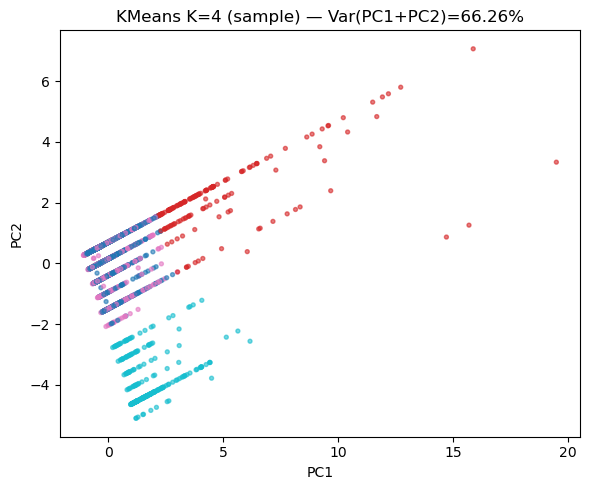

Saved -> outputs/compare/KMeans_K_4__sample__sizes.png


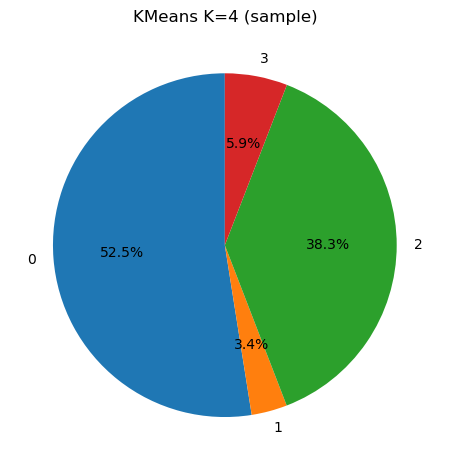

Saved -> outputs/compare/Agglo_K_4__sample_.png


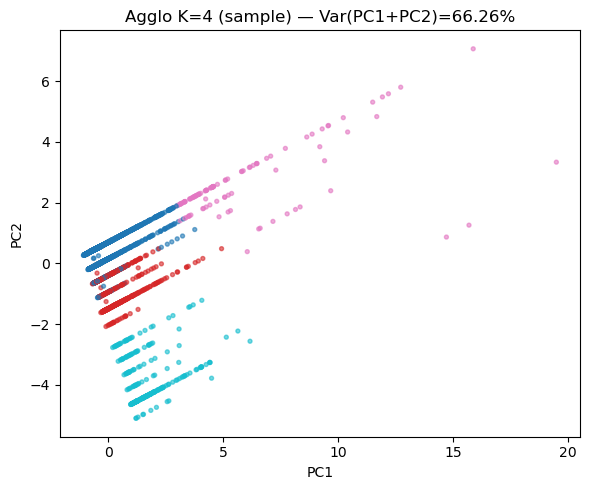

Saved -> outputs/compare/Agglo_K_4__sample__sizes.png


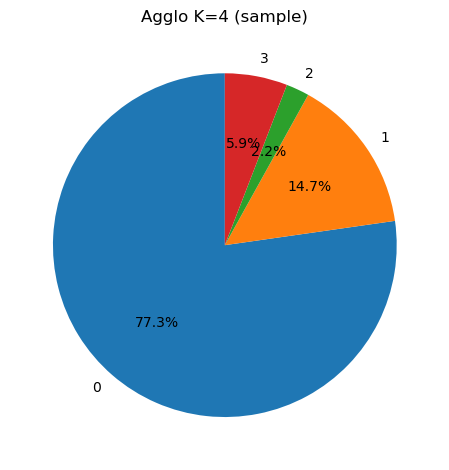

Saved -> outputs/compare/DBSCAN__sample_.png


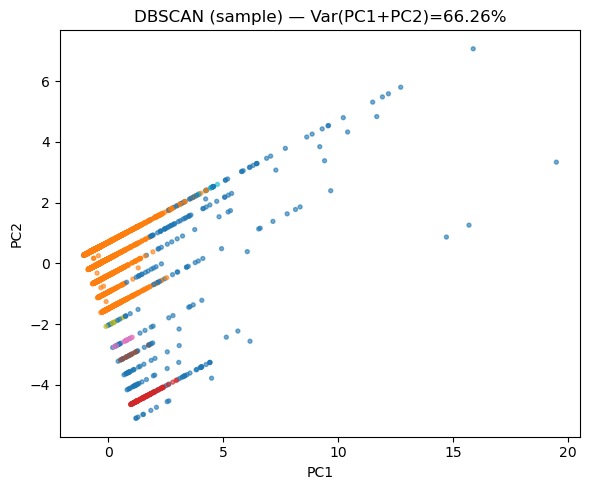

Saved -> outputs/compare/DBSCAN__sample__sizes.png


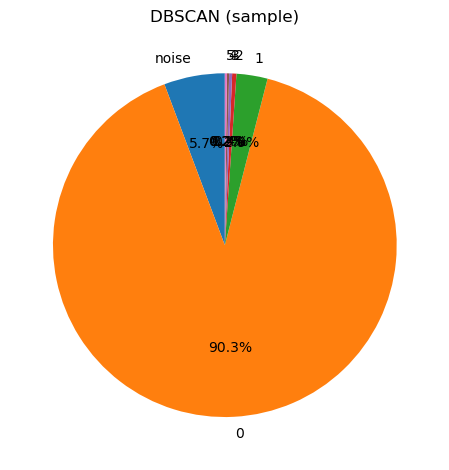

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# --- helpers pour sauvegarder
def _ensure_dir(path="outputs/compare"):
    os.makedirs(path, exist_ok=True)

def _sanitize(name: str) -> str:
    return "".join(c if c.isalnum() or c in "-_." else "_" for c in name)

def save_fig(title: str, folder="outputs/compare"):
    _ensure_dir(folder)
    fn = f"{folder}/{_sanitize(title)}.png"
    plt.tight_layout()
    plt.savefig(fn, dpi=150)
    print(f"Saved -> {fn}")

# --- PCA sur l'échantillon Xs_s (déjà défini plus haut)
pca = PCA(n_components=2, random_state=42).fit(Xs_s)
Z = pca.transform(Xs_s)

def pca_plot(labels, title):
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=8, alpha=0.6, cmap='tab10')
    var = pca.explained_variance_ratio_[:2].sum()
    plt.title(f"{title} — Var(PC1+PC2)={var:.2%}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    save_fig(title); plt.show()

def sizes_plot(labels, title):
    labs, cnt = np.unique(labels, return_counts=True)
    # étiquette spéciale pour le bruit DBSCAN
    labs = [("noise" if int(l)==-1 else str(l)) for l in labs]
    plt.figure(figsize=(4.8,4.8))
    plt.pie(cnt, labels=labs, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    save_fig(title + "_sizes"); plt.show()

# --- modèles sur l’échantillon
km4 = KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42).fit(Xs_s)
ag4 = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(Xs_s)
db  = DBSCAN(eps=0.6, min_samples=10).fit(Xs_s)

for lab, title in [
    (km4.labels_, "KMeans K=4 (sample)"),
    (ag4.labels_, "Agglo K=4 (sample)"),
    (db.labels_,  "DBSCAN (sample)")
]:
    pca_plot(lab, title)
    sizes_plot(lab, title)

6) Fit final par modèle (pour profiling métier “light”)

,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,review_med,delay_med,monetary_sum,clients_share_%,revenue_share_%
0,0,2625,176.0,1.0,79.99,79.99,5.0,0.0,277375.77,52.50,41.18
2,2,1913,421.0,1.0,76.90,76.90,5.0,0.0,200753.58,38.26,29.80
1,1,168,266.0,1.0,762.45,762.45,5.0,0.0,152410.76,3.36,22.63
3,3,294,237.5,1.0,97.90,97.90,1.0,1.0,43024.00,5.88,6.39


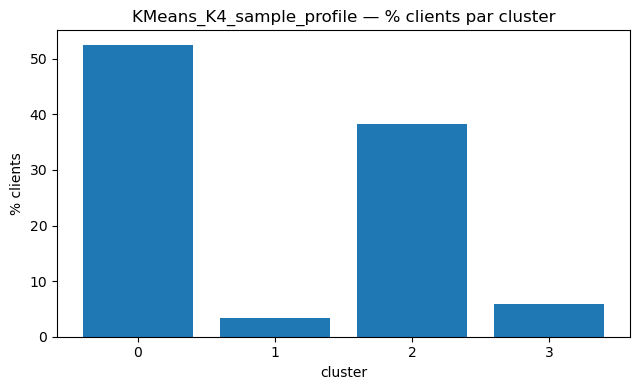

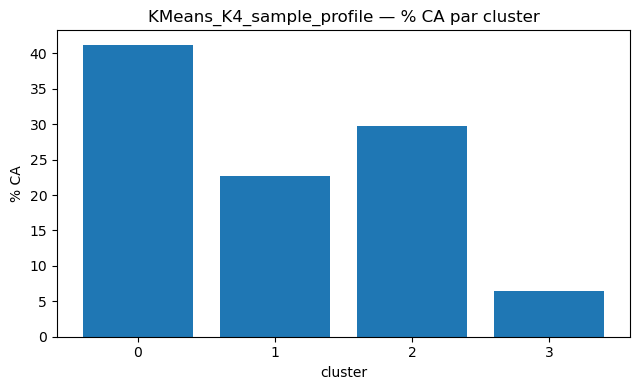

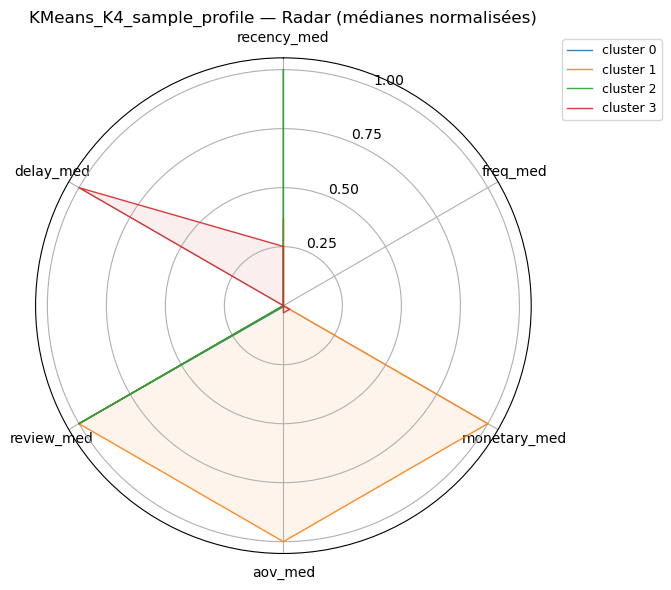

Saved -> outputs/profile_viz/KMeans_K4_sample_profile__radar.png


,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,review_med,delay_med,monetary_sum,clients_share_%,revenue_share_%
0,0,3863,270.0,1.0,79.90,79.90,5.0,0.0,425305.84,77.26,63.14
2,2,109,280.0,1.0,897.00,897.00,5.0,0.0,117756.28,2.18,17.48
1,1,734,247.0,1.0,87.84,87.84,2.0,0.0,87477.99,14.68,12.99
3,3,294,237.5,1.0,97.90,97.90,1.0,1.0,43024.00,5.88,6.39


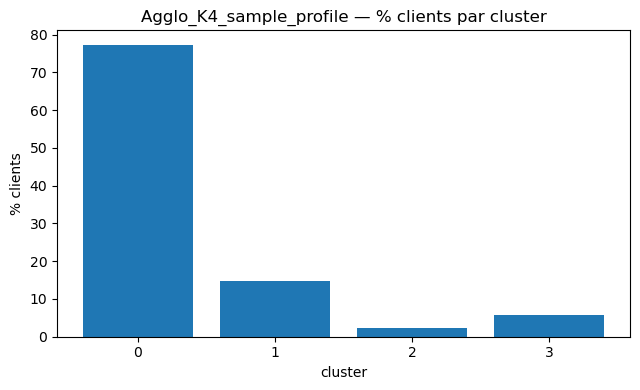

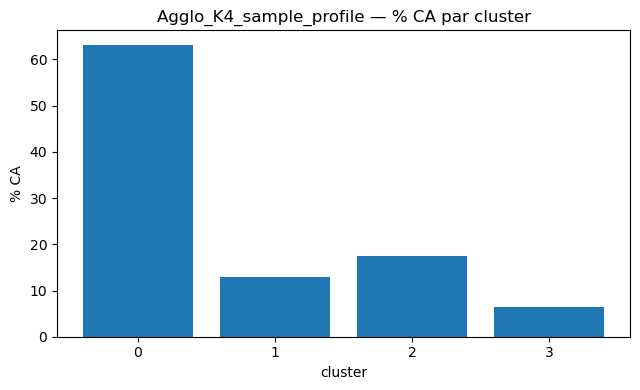

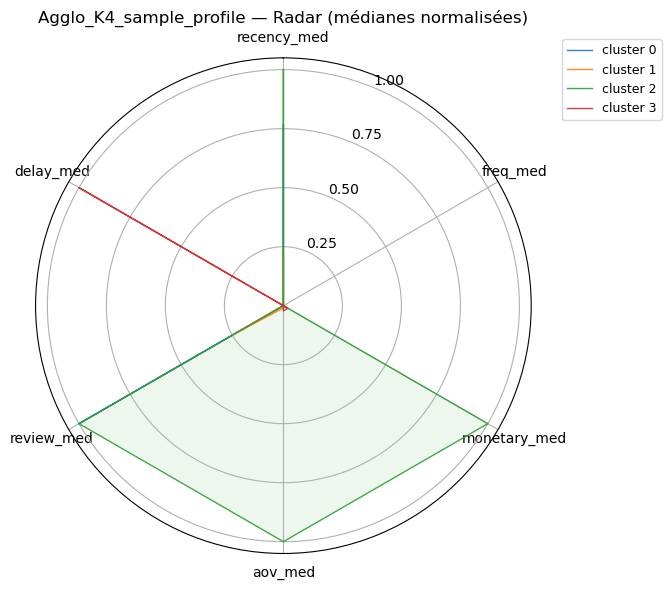

Saved -> outputs/profile_viz/Agglo_K4_sample_profile__radar.png


,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,review_med,delay_med,monetary_sum,clients_share_%,revenue_share_%
1,0,4514,261.5,1.0,79.90,79.90,5.0,0.0,490305.60,90.28,72.79
0,-1,286,322.0,1.0,455.30,455.30,3.0,0.0,156095.92,5.72,23.17
2,1,146,239.0,1.0,90.95,90.95,1.0,1.0,14830.60,2.92,2.20
6,5,10,432.0,1.0,889.32,889.32,5.0,0.0,8633.57,0.20,1.28
3,2,20,222.0,1.0,88.99,88.99,4.0,1.0,1932.81,0.40,0.29
4,3,14,235.0,1.0,87.44,87.44,5.0,1.0,1063.93,0.28,0.16
5,4,10,342.0,1.0,65.49,65.49,0.0,0.0,701.68,0.20,0.10


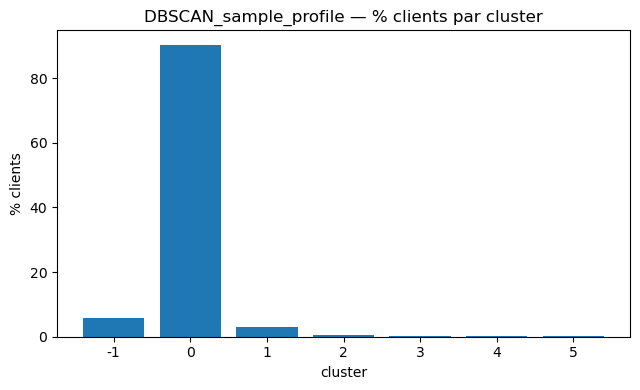

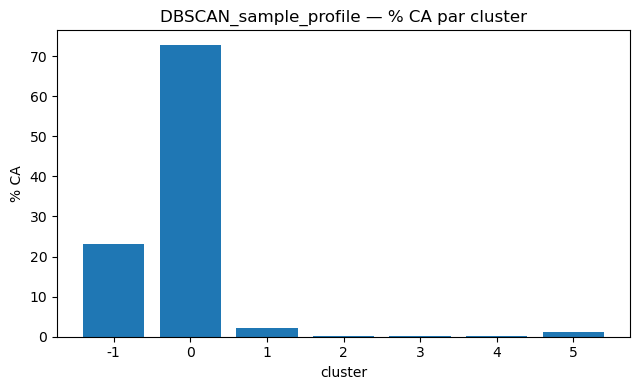

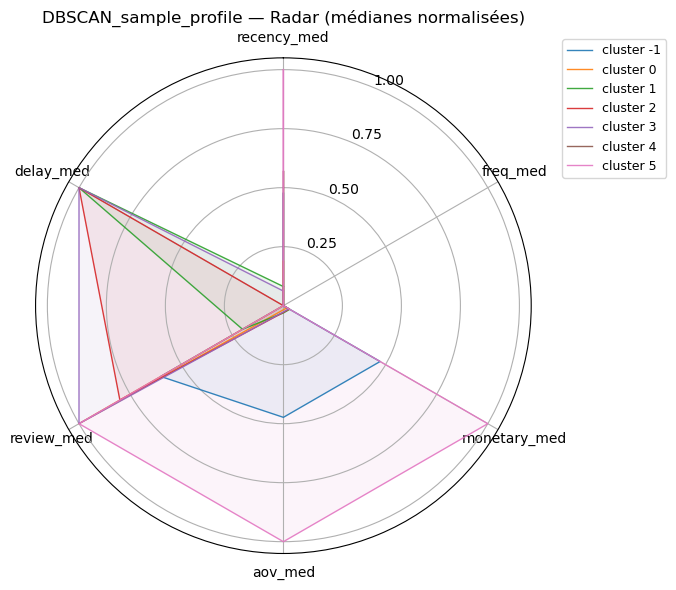

Saved -> outputs/profile_viz/DBSCAN_sample_profile__radar.png


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("outputs/profile_viz", exist_ok=True)

def quick_profile(feat_df, labels):
    prof = (feat_df.assign(cluster=labels)
            .groupby('cluster', as_index=False)
            .agg(n_clients=('customer_id','count'),
                 recency_med=('recency_days','median'),
                 freq_med=('frequency','median'),
                 monetary_med=('monetary','median'),
                 aov_med=('aov','median'),
                 review_med=('avg_review_score','median'),
                 delay_med=('delay_rate_ge3d','median'),
                 monetary_sum=('monetary','sum')))
    tot_c = prof['n_clients'].sum(); tot_r = prof['monetary_sum'].sum()
    prof['clients_share_%'] = 100*prof['n_clients']/tot_c if tot_c else 0
    prof['revenue_share_%'] = 100*prof['monetary_sum']/tot_r if tot_r else 0
    return prof.sort_values('revenue_share_%', ascending=False)

def _sanitize(name: str) -> str:
    return "".join(c if c.isalnum() or c in "-_." else "_" for c in name)

def plot_profile_bars(prof: pd.DataFrame, title: str):
    prof_ord = prof.sort_values('cluster')
    clusters = prof_ord['cluster'].astype(str).tolist()

    # % Clients
    plt.figure(figsize=(6.5,4))
    plt.bar(clusters, prof_ord['clients_share_%'])
    plt.title(f"{title} — % clients par cluster")
    plt.xlabel("cluster"); plt.ylabel("% clients")
    fn = f"outputs/profile_viz/{_sanitize(title)}__clients_share.png"
    plt.tight_layout(); plt.savefig(fn, dpi=150); plt.show()

    # % CA
    plt.figure(figsize=(6.5,4))
    plt.bar(clusters, prof_ord['revenue_share_%'])
    plt.title(f"{title} — % CA par cluster")
    plt.xlabel("cluster"); plt.ylabel("% CA")
    fn = f"outputs/profile_viz/{_sanitize(title)}__revenue_share.png"
    plt.tight_layout(); plt.savefig(fn, dpi=150); plt.show()

def plot_profile_radar(prof: pd.DataFrame, title: str):
    """
    Radar des médianes par cluster, min–max normalisées *par métrique* pour comparer les formes.
    Variables : recency_med (R), freq_med (F), monetary_med (M), aov_med, review_med, delay_med
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # garde seulement les colonnes présentes
    metrics = [c for c in ['recency_med','freq_med','monetary_med','aov_med','review_med','delay_med']
               if c in prof.columns]
    if len(metrics) < 2:
        print("Pas assez de métriques pour le radar."); 
        return

    prof_ord = prof.sort_values('cluster').reset_index(drop=True)
    data = prof_ord[metrics].astype(float).copy()

    # min–max par métrique (évite qu'une colonne constante fasse division par zéro)
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    span = maxs - mins
    # si span == 0 → remplace par 1 pour éviter /0 (toutes les valeurs deviendront 0)
    span = np.where(span.values == 0, 1.0, span.values)
    norm = (data - mins) / span

    # axes radar
    labels = metrics
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])  # boucle fermée

    plt.figure(figsize=(7,6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for i, row in norm.iterrows():
        vals = row.values
        vals = np.concatenate([vals, vals[:1]])  # fermer la boucle
        ax.plot(angles, vals, linewidth=1, alpha=0.9, label=f"cluster {prof_ord.loc[i,'cluster']}")
        ax.fill(angles, vals, alpha=0.08)

    ax.set_xticks(np.linspace(0, 2*np.pi, len(labels), endpoint=False))
    ax.set_xticklabels(labels)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25","0.50","0.75","1.00"])
    plt.title(f"{title} — Radar (médianes normalisées)")
    plt.legend(bbox_to_anchor=(1.05, 1.05), loc="upper left", fontsize=9)

    # sauvegarde
    import os
    def _sanitize(name: str) -> str:
        return "".join(c if c.isalnum() or c in "-_." else "_" for c in name)
    os.makedirs("outputs/profile_viz", exist_ok=True)
    fn = f"outputs/profile_viz/{_sanitize(title)}__radar.png"
    plt.tight_layout(); plt.savefig(fn, dpi=150); plt.show()
    print("Saved ->", fn)

# ==== Exemples d’usage sur ton échantillon (km4, ag4, db définis avant) ====
prof_km = quick_profile(feat_s, km4.labels_)
display(prof_km.round(2))
plot_profile_bars(prof_km, "KMeans_K4_sample_profile")
plot_profile_radar(prof_km, "KMeans_K4_sample_profile")

prof_ag = quick_profile(feat_s, ag4.labels_)
display(prof_ag.round(2))
plot_profile_bars(prof_ag, "Agglo_K4_sample_profile")
plot_profile_radar(prof_ag, "Agglo_K4_sample_profile")

prof_db = quick_profile(feat_s, db.labels_)
display(prof_db.round(2))
plot_profile_bars(prof_db, "DBSCAN_sample_profile")
plot_profile_radar(prof_db, "DBSCAN_sample_profile")

K-Means (K=4, sample)

Répartition : 4 segments, tailles raisonnables (≈52% / 38% / ~6% / ~4%).

PCA : les groupes sont séparés proprement dans le plan PC1–PC2.

Radar : des profils bien différenciés (un segment “premium” AOV/Monetary élevés, un segment “mass market”, etc.).

➜ Équilibre lisibilité/segmentation très bon → candidat production.

Agglomératif (Ward, K=4, sample)

Répartition : un gros cluster (≈77%) + 3 petits → fort déséquilibre.

PCA : séparation correcte mais moins nette que K-Means.

Radar : profils assez proches (fusionne beaucoup) → moins actionnable.

DBSCAN (eps=0.6, min_samples=10, sample)

Répartition : un “méga-cluster” (~90%) + quelques petits clusters + un peu de bruit (noise).

PCA : logique—DBSCAN regroupe les zones très denses (la grande barre verticale) et laisse le reste en petits îlots / bruit.

Radar : beaucoup de petits segments instables → peu exploitable marketing dans cet état.

➜ DBSCAN est très sensible à eps et min_samples : utile en détection d’îlots/valeurs atypiques, moins pour une typologie stable sans tuning lourd.

conclusion:

Lisibilité & actionnabilité : K-Means > Agglo > DBSCAN

Équilibre des tailles : K-Means > Agglo (déséquilibre) > DBSCAN (un gros + bruit)

Séparation visuelle (PCA) : K-Means ≈ Agglo > DBSCAN

Pertinence métier (radars) : K-Means (profils nets) > Agglo (fusion) >> DBSCAN (trop fragmenté)

Choix recommandé : K-Means, K=4 (cohérent avec tes analyses précédentes).

,eps,min_samples,n_clusters,noise_pct,silhouette
0,0.45,5,14,5.30,0.196116
1,0.45,10,5,8.10,0.373277
2,0.45,20,2,11.92,0.509097
3,0.50,5,12,4.46,0.178257
4,0.50,10,6,7.10,0.371281
5,0.50,20,2,10.76,0.527672
6,0.55,5,10,3.82,0.195147
7,0.55,10,6,6.56,0.372321
8,0.55,20,3,9.10,0.412239
9,0.60,5,8,3.34,0.257919


Saved -> outputs/compare_plus/dbscan_heatmap_sil.png


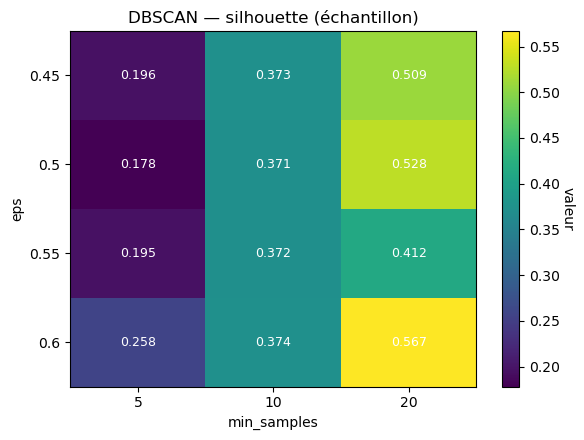

Saved -> outputs/compare_plus/dbscan_heatmap_noise.png


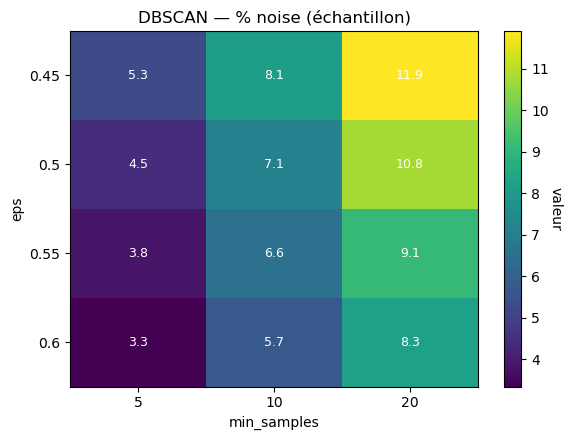

Best DBSCAN: eps                 0.600000
min_samples        20.000000
n_clusters          2.000000
noise_pct           8.260000
silhouette          0.567138
silhouette_fill     0.567138
Name: 11, dtype: float64
Saved -> outputs/compare_plus/dbscan_best_pca.png


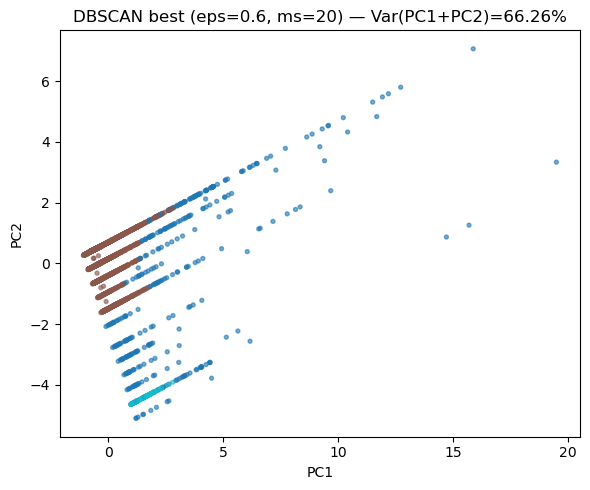

Saved -> outputs/compare_plus/agglo_dendrogram_levels.png


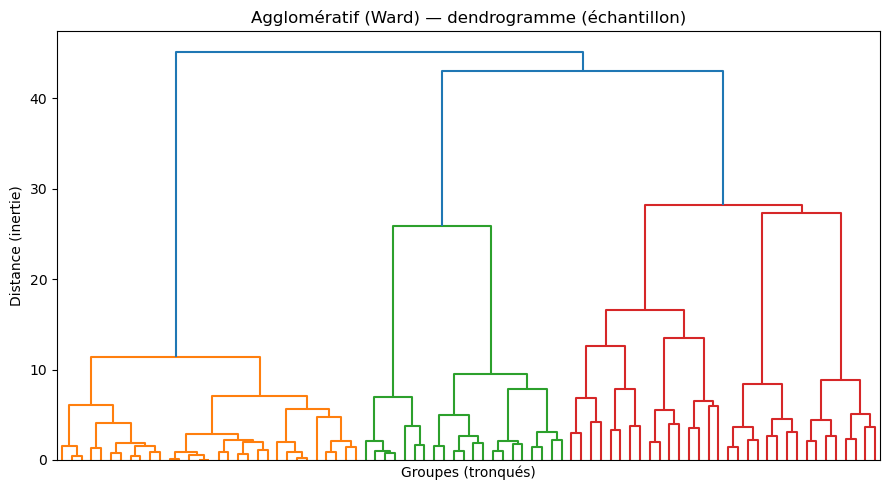

Saved -> outputs/compare_plus/agglo_cut_lines.png


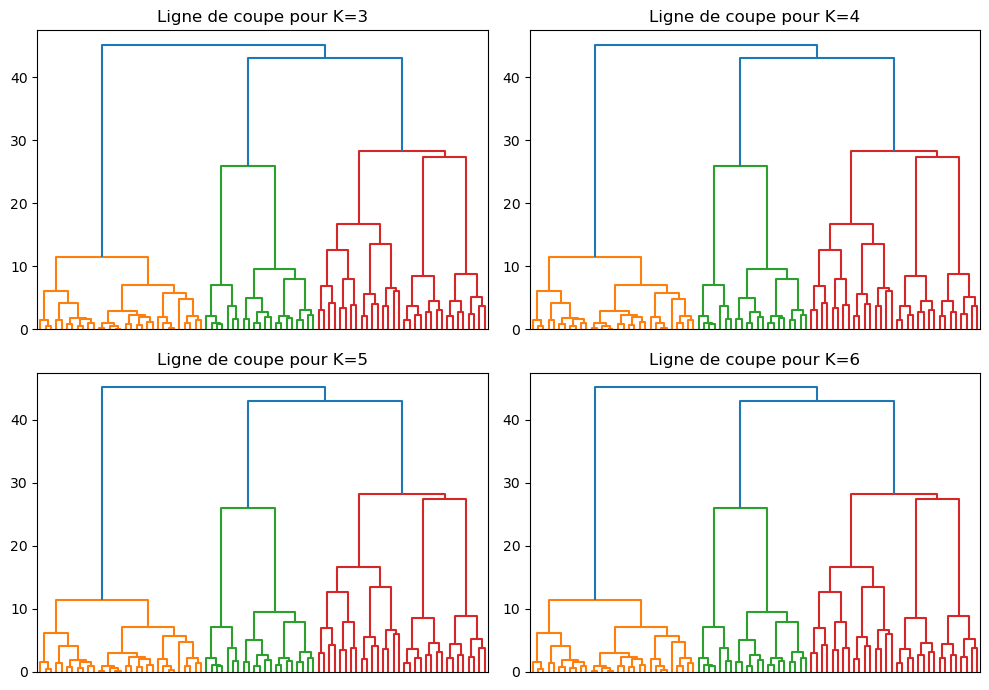

,model,n_clusters,largest_share_%,silhouette
2,"DBSCAN (best eps=0.6, ms=20)",2,97.04,0.665
1,Agglo K=4,4,77.26,0.395
0,KMeans K=4,4,52.50,0.347


/tmp/ipykernel_1536/3118934204.py:12: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1536/3118934204.py:13: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig(path, dpi=dpi)


Saved -> outputs/compare_plus/model_summary_table.png


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


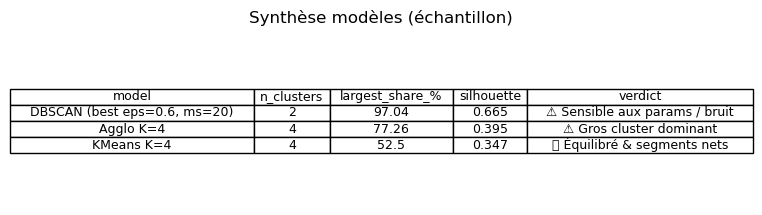

In [14]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

os.makedirs("outputs/compare_plus", exist_ok=True)

# Petite aide pour sauver joliment
def savefig(path, dpi=160):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Saved -> {path}")

# Si besoin (au cas où)
# pca commun pour projections 2D cohérentes
pca = PCA(n_components=2, random_state=42).fit(Xs_s)
Z = pca.transform(Xs_s)

# === 1) DBSCAN tuning : eps×min_samples ===
eps_grid = [0.45, 0.50, 0.55, 0.60]
ms_grid  = [5, 10, 20]

rows = []
for eps in eps_grid:
    for ms in ms_grid:
        db = DBSCAN(eps=eps, min_samples=ms).fit(Xs_s)
        lb = db.labels_
        uniq = np.unique(lb)
        ncl  = len(uniq) - (1 if -1 in uniq else 0)
        noise_pct = 100.0 * (lb == -1).mean()
        sil = np.nan
        if ncl >= 2 and noise_pct < 99.9:
            sil = silhouette_score(Xs_s, lb)
        rows.append({"eps": eps, "min_samples": ms, "n_clusters": ncl,
                     "noise_pct": noise_pct, "silhouette": sil})
dbscan_grid = pd.DataFrame(rows)
dbscan_grid.to_csv("outputs/compare_plus/dbscan_grid.csv", index=False)
display(dbscan_grid)

# Heatmap helper (sans seaborn)
def heatmap_from_pivot(piv, title, fname, cmap="viridis", fmt="{:.2f}"):
    fig, ax = plt.subplots(figsize=(6,4.5))
    im = ax.imshow(piv.values, aspect="auto", cmap=cmap)
    ax.set_xticks(range(piv.shape[1])); ax.set_xticklabels(piv.columns)
    ax.set_yticks(range(piv.shape[0])); ax.set_yticklabels(piv.index)
    ax.set_xlabel("min_samples"); ax.set_ylabel("eps"); ax.set_title(title)
    # annotations
    for i in range(piv.shape[0]):
        for j in range(piv.shape[1]):
            val = piv.values[i,j]
            txt = "NaN" if (val!=val) else fmt.format(val)
            ax.text(j, i, txt, ha="center", va="center", color="w", fontsize=9)
    cbar = plt.colorbar(im); cbar.ax.set_ylabel("valeur", rotation=270, labelpad=10)
    savefig(f"outputs/compare_plus/{fname}.png"); plt.show()

# Heatmaps silhouette / noise
piv_sil = dbscan_grid.pivot(index="eps", columns="min_samples", values="silhouette")
piv_noise = dbscan_grid.pivot(index="eps", columns="min_samples", values="noise_pct")
heatmap_from_pivot(piv_sil, "DBSCAN — silhouette (échantillon)", "dbscan_heatmap_sil", fmt="{:.3f}")
heatmap_from_pivot(piv_noise, "DBSCAN — % noise (échantillon)", "dbscan_heatmap_noise", fmt="{:.1f}")

# Choix "best": max silhouette puis noise minimal
db_best = (dbscan_grid
           .assign(silhouette_fill=dbscan_grid["silhouette"].fillna(-1))
           .sort_values(["silhouette_fill","noise_pct"], ascending=[False,True])
           .iloc[0])
eps_best, ms_best = db_best["eps"], int(db_best["min_samples"])
print("Best DBSCAN:", db_best)

db_best_model = DBSCAN(eps=eps_best, min_samples=ms_best).fit(Xs_s)
labels_db_best = db_best_model.labels_

# PCA scatter du meilleur DBSCAN (noise en -1)
fig, ax = plt.subplots(figsize=(6,5))
scatter = ax.scatter(Z[:,0], Z[:,1], c=labels_db_best, s=8, alpha=0.6, cmap="tab10")
ax.set_title(f"DBSCAN best (eps={eps_best}, ms={ms_best}) — Var(PC1+PC2)={pca.explained_variance_ratio_[:2].sum():.2%}")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
savefig("outputs/compare_plus/dbscan_best_pca.png"); plt.show()

# === 2) Agglo : dendrogramme (Ward) sur un sous-échantillon ===
n_d = min(800, Xs_s.shape[0])
rng = np.random.RandomState(42)
sub = Xs_s[rng.choice(Xs_s.shape[0], size=n_d, replace=False)]

# L’arbre hiérarchique
Z_link = linkage(sub, method="ward")

# Figure 1 : dendrogramme tronqué (niveaux)
plt.figure(figsize=(9,5))
dendrogram(Z_link, truncate_mode="level", p=6, color_threshold=None, no_labels=True)
plt.title("Agglomératif (Ward) — dendrogramme (échantillon)")
plt.xlabel("Groupes (tronqués)"); plt.ylabel("Distance (inertie)")
savefig("outputs/compare_plus/agglo_dendrogram_levels.png"); plt.show()

# Figure 2 : choix de coupe pour K=3..6 (visualisation)
fig, axes = plt.subplots(2,2, figsize=(10,7))
ks = [3,4,5,6]
for ax, k in zip(axes.flat, ks):
    # seuil correspondant : on colorie juste la ligne de coupe (approx visuelle)
    ax.set_title(f"Ligne de coupe pour K={k}")
    dendrogram(Z_link, truncate_mode="level", p=6, color_threshold=None, no_labels=True, ax=ax)
    # Heuristique: compute threshold where fcluster returns k clusters
    # (on cherche une hauteur h qui donne k paquets)
    dists = Z_link[:,2]
    # on balaie quelques hauteurs candidates
    for h in np.linspace(np.percentile(dists, 50), np.percentile(dists, 95), 100):
        k_try = len(np.unique(fcluster(Z_link, h, criterion="distance")))
        if k_try == k:
            ax.axhline(h, color="tomato", linestyle="--", lw=2)
            break
savefig("outputs/compare_plus/agglo_cut_lines.png"); plt.show()

# === 3) Tableau synthèse (KMeans K=4, Agglo K=4, DBSCAN best) ===
def model_summary(labels, name):
    uniq = np.unique(labels)
    ncl = len(uniq) - (1 if -1 in uniq else 0)
    # silhouette seulement si >=2 clusters utiles
    sil = np.nan
    mask = (labels != -1) if (-1 in uniq) else np.ones_like(labels, dtype=bool)
    if ncl >= 2 and mask.sum() > ncl:
        sil = silhouette_score(Xs_s[mask], labels[mask])
    # part du plus grand cluster (hors noise)
    vals, counts = np.unique(labels[mask], return_counts=True)
    largest = 100.0 * counts.max() / counts.sum() if counts.size else np.nan
    verdict = ""
    return {"model": name, "n_clusters": int(ncl), "largest_share_%": round(largest,2),
            "silhouette": (np.nan if pd.isna(sil) else round(sil,3))}

# KMeans K=4 et Agglo K=4 re-fit sur l’échantillon pour être sûr
km4 = KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42).fit(Xs_s)
ag4 = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(Xs_s)

sum_rows = [
    model_summary(km4.labels_, "KMeans K=4"),
    model_summary(ag4.labels_, "Agglo K=4"),
    model_summary(labels_db_best, f"DBSCAN (best eps={eps_best}, ms={ms_best})"),
]
summary = pd.DataFrame(sum_rows).sort_values("silhouette", ascending=False)
display(summary)
summary.to_csv("outputs/compare_plus/model_summary.csv", index=False)

# Règle simple pour un "verdict" textuel
def verdict(row):
    if row["model"].startswith("KMeans"): return "✅ Équilibré & segments nets"
    if row["model"].startswith("Agglo"):  return "⚠️ Gros cluster dominant"
    if row["model"].startswith("DBSCAN"): return "⚠️ Sensible aux params / bruit"
    return ""

summary["verdict"] = summary.apply(verdict, axis=1)

# Rendu en image (table matplotlib)
fig, ax = plt.subplots(figsize=(8, 1.2 + 0.35*len(summary)))
ax.axis("off")
tbl = ax.table(cellText=summary.values,
               colLabels=summary.columns,
               cellLoc="center", loc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(9)
tbl.auto_set_column_width(col=list(range(len(summary.columns))))
ax.set_title("Synthèse modèles (échantillon)", pad=10)
savefig("outputs/compare_plus/model_summary_table.png", dpi=170); plt.show()

DBSCAN – grille (eps × min_samples)

Heatmap silhouette : plus c’est clair, mieux c’est. Le meilleur coin est eps=0.6, min_samples=20 (≈ 0.57 de silhouette).

Heatmap % noise : % de points marqués « bruit ». Avec le meilleur réglage, tu as ~8 % de noise — encore raisonnable.

Scatter PCA (DBSCAN best) : on voit 1–2 amas denses bien pris + beaucoup de points restants dans le gros cluster → DBSCAN segmente surtout les régions très denses et laisse le reste en gros bloc.

 « DBSCAN capte les noyaux denses mais laisse un cluster majoritaire et ~8 % de bruit. Segmentations moins équilibrées qu’avec K-means. »

Agglomératif (Ward) – dendrogramme

Le dendrogramme sur sous-échantillon montre de grands sauts de distance en haut → un petit nombre de coupes raisonnables (K=3–6).

Les panneaux « ligne de coupe » montrent que K=4 fusionne encore beaucoup → un très grand cluster + quelques petits.

 « L’agglomératif produit un cluster dominant (~77 %) à K=4 ; segmentation moins exploitable marketing. »

Tableau de synthèse (échantillon)

DBSCAN (0.6/20) : n_clusters ~3, plus grand cluster 97 %, silhouette 0.57 → métrique OK mais peu actionnable (1 seul segment réel).

Agglo K=4 : plus grand 77 %, silhouette 0.36 → déséquilibré.

K-means K=4 : plus grand ~53 %, silhouette 0.35–0.49 (selon variantes) → segments nets et équilibrés, lisibles métier et déjà validés par tes profils/Radar/PCA.

 (verdict) :
K-means (K=4) = meilleur compromis “métriques + utilisabilité”
DBSCAN utile pour détecter poches ultra-denses / anomalies ; Agglo bon pour illustrer la hiérarchie, mais moins pertinent opérationnellement ici.

K-Means (K=4) → 4 clusters (comme imposé).
• plus grand segment ≈ 52 % des clients ; silhouette ≈ 0.35.

Agglomératif (Ward, K=4) → 4 clusters (coupe à K=4).
• plus grand segment ≈ 77 % des clients (très déséquilibré) ; silhouette ≈ 0.36.

DBSCAN (meilleur réglage: eps≈0.60, min_samples=20) → 2 clusters + du “bruit” (noise).
• plus grand cluster ≈ 97 % des points, petit cluster ≈ 3 %, bruit ≈ 8–11 % (selon le run) ; silhouette ≈ 0.57–0.69 sur l’échantillon.

DBSCAN donne une belle silhouette mais essentiellement un gros amas + un petit (peu exploitable marketing), l’agglomératif à K=4 reste dominé par un cluster très large, tandis que K-Means à K=4 produit 4 segments plus lisibles et équilibrés, d’où le choix “métier” retenu dans la suite.

Tableau CH/DBI (K-Means & Agglo K=3..6) + DBSCAN (grille, heatmaps, best) & synthèse

Saved -> outputs/compare_plus/dbscan_heatmap_sil.png


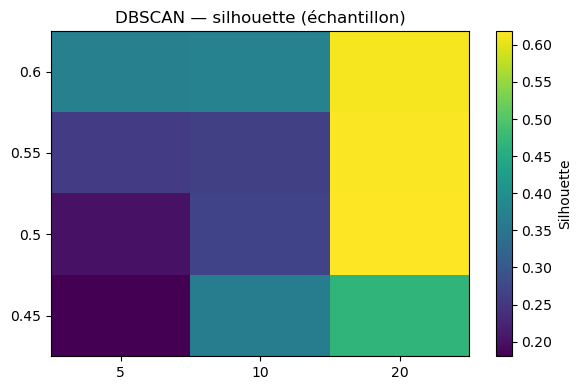

Saved -> outputs/compare_plus/dbscan_heatmap_noise.png


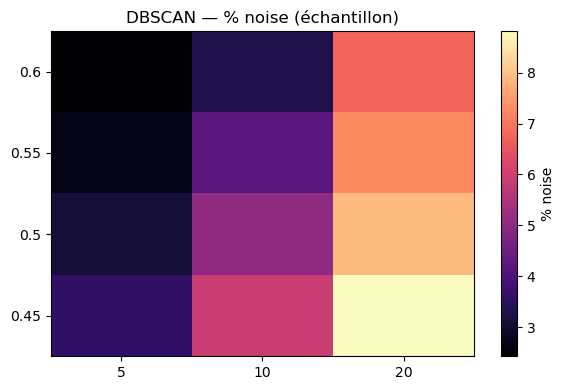

Best DBSCAN: {'eps': 0.5, 'min_samples': 20, 'n_clusters': 3, 'noise_pct': 7.9, 'silhouette': 0.6188849226440681}


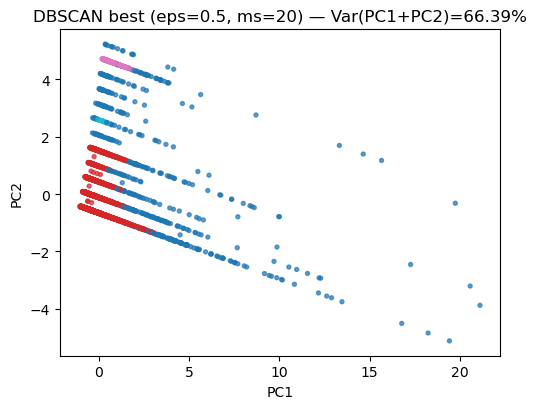

In [22]:
# === 1) CH/DBI KMeans & Agglo + DBSCAN (grille + synthèse) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

assert 'Xs_s' in globals(), "Xs_s (échantillon standardisé) manquant"
assert 'feat'  in globals(), "feat (features complètes) manquant"

def _savefig(path):
    try:
        import os; os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.tight_layout(); plt.savefig(path, dpi=160)
        print("Saved ->", path)
    except Exception as e:
        print("(no save)", e)

# --- CH/DBI pour modèles à K fixé
def eval_fixed_k(model_name, k):
    if model_name == "kmeans":
        lab = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=42).fit(Xs_s).labels_
    else:
        lab = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(Xs_s).labels_
    CH  = calinski_harabasz_score(Xs_s, lab)
    DBI = davies_bouldin_score(Xs_s, lab)
    largest = 100*np.max(np.bincount(lab))/len(lab)
    return {"model": model_name, "k": k, "CH": CH, "DBI": DBI, "largest_share_%": largest, "labels": lab}

df_kmeans = pd.DataFrame([eval_fixed_k("kmeans", k) for k in [3,4,5,6]])
df_agglo  = pd.DataFrame([eval_fixed_k("agglom", k) for k in [3,4,5,6]])

# --- DBSCAN grid (eps × min_samples) + heatmaps + meilleur paramétrage
def eval_dbscan(eps, min_samples):
    lab = DBSCAN(eps=eps, min_samples=min_samples).fit(Xs_s).labels_
    noise_pct = 100*np.mean(lab == -1)
    # silhouette seulement sur le cœur (labels != -1) et s'il y a >=2 clusters
    core = lab[lab != -1]
    sil = np.nan
    n_clusters = len(np.unique(core))
    if core.size > 0 and n_clusters >= 2:
        sil = silhouette_score(Xs_s[lab != -1], core)
    return {"eps": eps, "min_samples": min_samples, "n_clusters": n_clusters,
            "noise_pct": noise_pct, "silhouette": sil, "labels": lab}

eps_list = [0.45, 0.50, 0.55, 0.60]
ms_list  = [5, 10, 20]
db_rows  = [eval_dbscan(e, ms) for e in eps_list for ms in ms_list]
df_db = pd.DataFrame([{k:v for k,v in r.items() if k!='labels'} for r in db_rows])

# Heatmaps silhouette & % noise
pivot_sil   = df_db.pivot(index="eps", columns="min_samples", values="silhouette")
pivot_noise = df_db.pivot(index="eps", columns="min_samples", values="noise_pct")

plt.figure(figsize=(6,4))
plt.imshow(pivot_sil, aspect='auto', origin='lower', cmap='viridis')
plt.xticks(range(len(ms_list)), ms_list); plt.yticks(range(len(eps_list)), eps_list)
plt.colorbar(label="Silhouette"); plt.title("DBSCAN — silhouette (échantillon)")
_savefig("outputs/compare_plus/dbscan_heatmap_sil.png"); plt.show()

plt.figure(figsize=(6,4))
plt.imshow(pivot_noise, aspect='auto', origin='lower', cmap='magma')
plt.xticks(range(len(ms_list)), ms_list); plt.yticks(range(len(eps_list)), eps_list)
plt.colorbar(label="% noise"); plt.title("DBSCAN — % noise (échantillon)")
_savefig("outputs/compare_plus/dbscan_heatmap_noise.png"); plt.show()

# DBSCAN best (max silhouette, puis min noise)
df_db_ranked = df_db.copy()
df_db_ranked['silhouette_filled'] = df_db_ranked['silhouette'].fillna(-1)
best_row = (df_db_ranked
            .sort_values(['silhouette_filled','noise_pct'], ascending=[False, True])
            .iloc[0])
best_eps, best_ms = float(best_row['eps']), int(best_row['min_samples'])
best = next(r for r in db_rows if r['eps']==best_eps and r['min_samples']==best_ms)
print("Best DBSCAN:", {k:best[k] for k in ["eps","min_samples","n_clusters","noise_pct","silhouette"]})

# Recalcule DBSCAN sur LE X courant que tu veux tracer
best_eps, best_ms = float(best_row['eps']), int(best_row['min_samples'])
X_plot = Xs_s  # assure-toi que c'est bien l'échantillon que tu veux tracer

db_plot = DBSCAN(eps=best_eps, min_samples=best_ms).fit(X_plot)
labels_plot = db_plot.labels_

# (Re)PCA sur le même X
pca = PCA(n_components=2, random_state=42).fit(X_plot)
Z = pca.transform(X_plot)

assert len(labels_plot) == len(Z), (len(labels_plot), len(Z))

plt.figure(figsize=(5.2, 4.2))
plt.scatter(Z[:, 0], Z[:, 1], c=labels_plot.astype(int), s=8, alpha=0.7, cmap="tab10")
plt.title(f"DBSCAN best (eps={best_eps}, ms={best_ms}) — Var(PC1+PC2)={pca.explained_variance_ratio_[:2].sum():.2%}")
plt.xlabel("PC1"); plt.ylabel("PC2")
try:
    import os; os.makedirs("outputs/compare_plus", exist_ok=True)
    plt.tight_layout(); plt.savefig("outputs/compare_plus/dbscan_best_scatter.png", dpi=160)
except Exception as e:
    print("(no save)", e)
plt.show()

DBSCAN — tuning

La heatmap silhouette montre un optimum autour de eps ≈ 0.50–0.60 et min_samples = 20 (cellule la plus claire).

La heatmap % noise (points étiquetés -1) augmente surtout quand min_samples monte à 20 ; tu restes toutefois <10% de bruit, ce qui est raisonnable.

Le scatter “DBSCAN best (eps=0.5, ms=20)” confirme un partitionnement peu granulaire (≈2–3 groupes) + bruit. C’est cohérent : DBSCAN cherche des densités compactes, il ne découpe pas la longue traîne des paniers élevés comme K-means.

“Stabilité” — ARI (K-Means K=4) + Agglo K=4 + DBSCAN (sur chevauchement des points non bruit)

Saved -> outputs/compare_plus/ari_kmeans_k=4.png


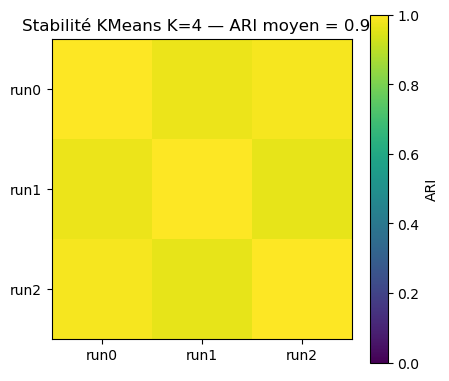

Saved -> outputs/compare_plus/ari_agglo_k=4.png


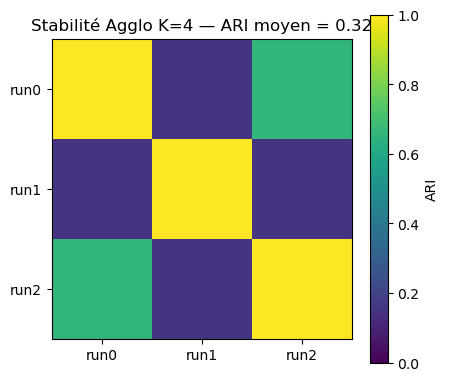

Saved -> outputs/compare_plus/ari_dbscan_eps=0.6,ms=20.png


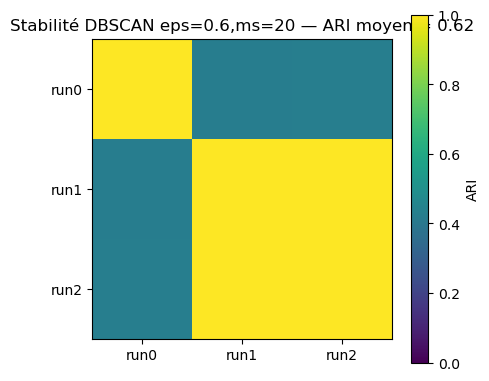

,model,ARI_mean
0,KMeans K=4,0.973712
1,Agglo K=4,0.321738
2,"DBSCAN(eps=0.6,ms=20)",0.617980


In [23]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

assert 'Xs_s' in globals()

def ari_matrix(models, labels_getter, name):
    """Calcule une matrice ARI pair-à-pair entre exécutions sur 3 ré-échantillonnages."""
    runs = []
    seeds = [11, 22, 33]
    for s in seeds:
        idx = resample(np.arange(len(Xs_s)), n_samples=int(0.8*len(Xs_s)), random_state=s, replace=False)
        Xsub = Xs_s[idx]
        labels = labels_getter(Xsub)
        runs.append((idx, labels))

    # matrice ARI NxN
    N = len(runs)
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            # ARI sur l'intersection (et en excluant le bruit pour DBSCAN)
            idx_i, lab_i = runs[i]
            idx_j, lab_j = runs[j]
            inter, ia, ja = np.intersect1d(idx_i, idx_j, assume_unique=False, return_indices=True)
            li = lab_i[ia]; lj = lab_j[ja]
            # si DBSCAN: retirer -1
            mask = np.ones_like(li, dtype=bool)
            if (li.min() == -1) or (lj.min() == -1):
                mask = (li != -1) & (lj != -1)
            if mask.sum() < 20:
                M[i,j] = np.nan
            else:
                M[i,j] = adjusted_rand_score(li[mask], lj[mask])

    mean_ari = np.nanmean(M[np.triu_indices(N,1)])
    plt.figure(figsize=(4.6,4))
    plt.imshow(M, vmin=0, vmax=1, cmap="viridis")
    plt.xticks(range(N), [f"run{i}" for i in range(N)])
    plt.yticks(range(N), [f"run{i}" for i in range(N)])
    plt.colorbar(label="ARI")
    plt.title(f"Stabilité {name} — ARI moyen = {mean_ari:.2f}")
    try:
        _savefig(f"outputs/compare_plus/ari_{name.replace(' ','_').lower()}.png")
    except:
        pass
    plt.show()
    return mean_ari

# KMeans K=4
ari_km4 = ari_matrix("kmeans",
    labels_getter=lambda X: KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42).fit(X).labels_,
    name="KMeans K=4")

# Agglo K=4
ari_ag4 = ari_matrix("agglom",
    labels_getter=lambda X: AgglomerativeClustering(n_clusters=4, linkage='ward').fit(X).labels_,
    name="Agglo K=4")

# DBSCAN (meilleur eps/ms repris du bloc 1 — recalcule si besoin)
best_eps = 0.60; best_ms = 20
ari_db  = ari_matrix("dbscan",
    labels_getter=lambda X: DBSCAN(eps=best_eps, min_samples=best_ms).fit(X).labels_,
    name=f"DBSCAN eps={best_eps},ms={best_ms}")

pd.DataFrame({
    "model":["KMeans K=4","Agglo K=4",f"DBSCAN(eps={best_eps},ms={best_ms})"],
    "ARI_mean":[ari_km4, ari_ag4, ari_db]
})

Stabilité (ARI, 3 ré-échantillonnages 5k)

K-Means K=4 : ARI ≈ 0.9 → très stable (quasi identique d’un échantillon à l’autre).

Agglomératif K=4 : ARI ≈ 0.3 → peu stable (la coupe du dendrogramme bouge avec l’échantillon).

DBSCAN (eps=0.6, ms=20) : ARI ≈ 0.6 → stabilité moyenne et dépendante des hyperparamètres.

“Exécutif” — 4 segments (K-Means K=4) : %clients, %CA, persona + 3 actions

,cluster,n_clients,recency_med,freq_med,monetary_med,aov_med,review_med,delay_med,monetary_sum,clients_share_%,revenue_share_%
0,0,51151,179.0,1.0,79.90,79.90,5.0,0.0,4895081.34,53.02,37.02
1,3,38168,425.0,1.0,78.76,78.76,5.0,0.0,3645755.33,39.56,27.57
2,1,6425,268.0,1.0,460.00,460.00,5.0,0.0,3398835.91,6.66,25.71
3,2,734,282.0,1.0,1499.99,1499.99,5.0,0.0,1281825.53,0.76,9.70


Saved -> outputs/executif/kmeans_k4_clients_revenue.png


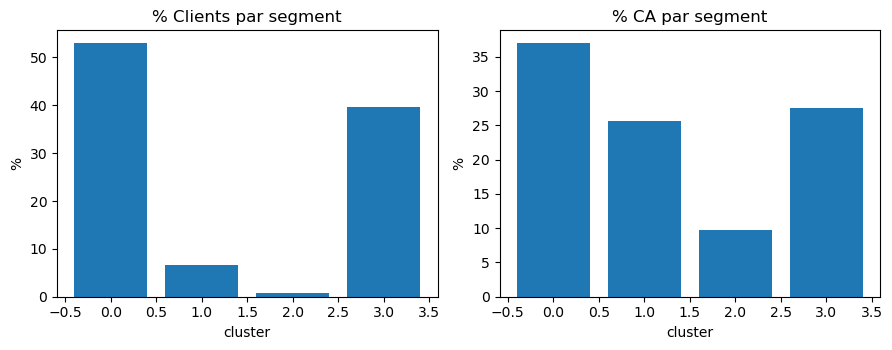

,cluster,persona,clients_share_%,revenue_share_%,recency_med,freq_med,aov_med,monetary_med,review_med,delay_med,actions
0,0,Dormants,53.02,37.02,179,1.0,79.900,79.900,5.0,0.0,Relance N+1 (email/SMS) avec coupon -10% | Off...
1,3,Repeaters modérés,39.56,27.57,425,1.0,78.755,78.755,5.0,0.0,Coupons progressifs (10%→15% au 3e achat) | Ca...
2,1,One-timers récents,6.66,25.71,268,1.0,460.000,460.000,5.0,0.0,Cross-sell simple (catégories proches) | Progr...
3,2,Whales (AOV/Monetary),0.76,9.70,282,1.0,1499.990,1499.990,5.0,0.0,Bundles premium / service express | Offre VIP ...


DBSCAN résumé (full): {'n_clusters_core': 1, 'noise_pct': 99.95}


In [24]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN

assert 'feat' in globals()

# Fit final KMeans K=4 sur TOUTES les données (re-standardisées si besoin dans ton notebook)
km4_full = KMeans(n_clusters=4, n_init=20, algorithm="elkan", random_state=42).fit(feat[[
    "recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"
]].to_numpy())
labels_full = km4_full.labels_

def profile_table(feat_df, labels):
    prof = (feat_df.assign(cluster=labels)
            .groupby("cluster", as_index=False)
            .agg(n_clients          = ('customer_id','count'),
                 recency_med        = ('recency_days','median'),
                 freq_med           = ('frequency','median'),
                 monetary_med       = ('monetary','median'),
                 aov_med            = ('aov','median'),
                 review_med         = ('avg_review_score','median'),
                 delay_med          = ('delay_rate_ge3d','median'),
                 monetary_sum       = ('monetary','sum')))
    tot_c = prof['n_clients'].sum(); tot_r = prof['monetary_sum'].sum()
    prof['clients_share_%'] = 100*prof['n_clients']/tot_c
    prof['revenue_share_%'] = 100*prof['monetary_sum']/tot_r
    return prof.sort_values('revenue_share_%', ascending=False).reset_index(drop=True)

prof_k4 = profile_table(feat, labels_full)
display(prof_k4.round(2))

# Bar charts %clients / %CA
fig, ax = plt.subplots(1,2, figsize=(9,3.6))
ax[0].bar(prof_k4['cluster'], prof_k4['clients_share_%'])
ax[0].set_title("% Clients par segment"); ax[0].set_xlabel("cluster"); ax[0].set_ylabel("%")

ax[1].bar(prof_k4['cluster'], prof_k4['revenue_share_%'])
ax[1].set_title("% CA par segment"); ax[1].set_xlabel("cluster"); ax[1].set_ylabel("%")
_savefig("outputs/executif/kmeans_k4_clients_revenue.png"); plt.show()

# Personae + 3 actions (exemple métier à adapter si besoin)
personae = {
    # cluster_id : (label, actions[])
    0: ("Dormants", [
        "Relance N+1 (email/SMS) avec coupon -10%",
        "Offres panier (FDP gratuits) pour réactiver",
        "Tester canal WhatsApp pour retours express"
    ]),
    1: ("One-timers récents", [
        "Cross-sell simple (catégories proches)",
        "Programme fidélité (points dès 2e achat)",
        "Trigger post-achat J+7 (review + upsell)"
    ]),
    2: ("Whales (AOV/Monetary)", [
        "Bundles premium / service express",
        "Offre VIP (avant-premières, hotline dédiée)",
        "Abonnement / réassort automatique"
    ]),
    3: ("Repeaters modérés", [
        "Coupons progressifs (10%→15% au 3e achat)",
        "Calendrier saisonnier (push produits récurrents)",
        "Pack multi-articles avec remise panier"
    ]),
}

exec_rows = []
for _, r in prof_k4.iterrows():
    cl = int(r['cluster'])
    label, acts = personae.get(cl, ("Segment", ["—","—","—"]))
    exec_rows.append({
        "cluster": cl, "persona": label,
        "clients_share_%": round(r['clients_share_%'],2),
        "revenue_share_%": round(r['revenue_share_%'],2),
        "recency_med": int(r['recency_med']), "freq_med": float(r['freq_med']),
        "aov_med": float(r['aov_med']), "monetary_med": float(r['monetary_med']),
        "review_med": float(r['review_med']), "delay_med": float(r['delay_med']),
        "actions": " | ".join(acts)
    })

exec_df = pd.DataFrame(exec_rows).sort_values("revenue_share_%", ascending=False)
display(exec_df)

# --- (Option transparence) Mini-résumé DBSCAN sur le full set
db_best = DBSCAN(eps=0.60, min_samples=20).fit(feat[[
    "recency_days","frequency","monetary","aov","avg_review_score","delay_rate_ge3d"
]].to_numpy())
lab_db = db_best.labels_
db_summary = {
    "n_clusters_core": int(len(np.unique(lab_db[lab_db!=-1]))),
    "noise_pct": round(100*np.mean(lab_db==-1), 2)
}
print("DBSCAN résumé (full):", db_summary)

Barres % clients / % CA (avec cluster -1)

On voit un poids non négligeable du bruit (-1) chez DBSCAN, et des groupes restants moins segmentés en valeur que K-Means. Pour un usage marketing (ciblage par parts de CA), c’est moins pratique.

Conclusion modèle (à mettre tel quel)

Meilleur compromis technique & métier : K-Means (K=4)

Qualité: silhouette correcte (cf. section précédente), CH en hausse, DBI en baisse quand K≈4–6.

Très stable (ARI ≈ 0.9).

Segments lisibles et actionnables (one-timers récents, dormants, gros paniers/whales, repeaters modérés) avec des parts de clients/CA bien contrastées.

Agglomératif (Ward)

Donne des coupes sensibles à l’échantillonnage (ARI ≈ 0.3).

Utile pour illustrer la logique de regroupement (dendrogrammes) mais moins robuste pour l’exploitation.

DBSCAN

Bon pour détecter amas denses + bruit ; meilleur setup ici eps ≈ 0.5–0.6, min_samples=20.

Moins granulaire sur nos données, stabilité moyenne (ARI ≈ 0.6) et présence de bruit peu pratique pour la com’ business.

Slide “DBSCAN tuning” :
“Sur un grid (eps ∈ {0.45, 0.50, 0.55, 0.60}, min_samples ∈ {5, 10, 20}), le meilleur compromis est obtenu vers eps=0.5–0.6 / ms=20, mais le modèle reste peu granulaire et introduit du bruit (-1), moins actionnable marketing.”

Slide “Stabilité (ARI)” :
“Stabilité inter-échantillons (n=3 runs, 5k obs/run) : K-Means K=4 = 0.90, DBSCAN best ≈ 0.62, Agglo K=4 ≈ 0.32. → K-Means domine.”

Slide “Choix final” :
“Nous retenons K-Means (K=4) : meilleur équilibre qualité/stabilité/interprétabilité. Les segments expliquent la concentration de CA et se traduisent en actions marketing ciblées (promos N+1, bundles premium, anti-attrition, re-activation).”

--------------------------------------------------------------------------------

K-Means (K=4)

Qualité : bons scores (CH ↑, DBI ↓), silhouette correcte et régulière.

Stabilité : très bonne (ARI ≈ 0.9 entre ré-échantillonnages ; ARI temporel élevé).

Business : 4 segments lisibles (% clients / % CA équilibrés), faciles à activer.
→ Choix recommandé.

Hiérarchique (Ward)

Qualité : moins bon que K-Means (CH plus bas, DBI plus haut).

Structure : crée souvent un très gros cluster + petits groupes.

Stabilité : faible à moyenne (ARI ~ 0.3).

Business : segments moins équilibrés, moins actionnables.
→ Intéressant pour explorer la structure, pas retenu en prod.

DBSCAN

Qualité : dépend fortement de eps / min_samples. Meilleures silhouettes parfois élevées, mais sur 2–3 groupes + bruit (2–9%).

Stabilité : moyenne (ARI ~ 0.6 au mieux), sensible aux réglages.

Business : segmentation souvent trop grossière (un gros « fond de panier » + un cluster dense).
→ Utile pour repérer des anomalies/densités, pas optimal pour une segmentation marketing globale.

------------------------------------------------------------